In [ ]:
##https://github.com/hufsaim/T10402201/blob/master/notebook/ch06_SimpleConvNet.ipynb 참고문헌

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model_ft = models.resnet18(pretrained=True)
best_model_wts = copy.deepcopy(model_ft.state_dict())


batch_size = 8
num_epochs = 20

model_ft.conv1 = nn.Conv2d(3,64,7,1,3, bias=False)
model_ft.layer2[0].conv1 = nn.Conv2d(64,128,3,1,1, bias=False)
model_ft.layer2[0].downsample[0] = nn.Conv2d(64,128,1,1,0, bias=False)

model_ft.load_state_dict(best_model_wts)


for param in model_ft.parameters():
    param.requires_grad = True


model_ft.fc = nn.Sequential(nn.Linear(in_features=512, out_features=5, bias=True), nn.Dropout(p = 0))
model_ft.to(device)

data_dir = "/content/drive/MyDrive/face/images/"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
def cutt(images) : 
  cut = images

  a=torch.zeros(64,64)
  a[5:30] = 1
  
  a=a.to(device)
  cut=cut.to(device)

  b = cut * a
  b=b.to(device)

  return b

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = cutt(inputs)
                labels = labels.to(device)
                

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            


            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.tolist())
            else :
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.tolist())
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model,train_loss,val_loss,train_acc,val_acc

In [4]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD([
                {'params': model_ft.layer1.parameters(),'lr' : 1e-6},
                {'params': model_ft.layer2.parameters(),'lr' : 1e-5},
                {'params': model_ft.layer3.parameters(),'lr' : 1e-4},
                {'params': model_ft.layer4.parameters(),'lr' : 1e-3},
                {'params': model_ft.fc.parameters(), 'lr': 1e-2}
            ],momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model,train_loss,val_loss,train_acc,val_acc = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 2.4992 Acc: 0.3181
val Loss: 1.5107 Acc: 0.3974

Epoch 1/19
----------
train Loss: 1.5697 Acc: 0.4169
val Loss: 1.2456 Acc: 0.4962

Epoch 2/19
----------
train Loss: 1.4109 Acc: 0.4715
val Loss: 1.2115 Acc: 0.5459

Epoch 3/19
----------
train Loss: 1.2534 Acc: 0.5313
val Loss: 1.1495 Acc: 0.5666

Epoch 4/19
----------
train Loss: 1.0567 Acc: 0.6028
val Loss: 1.3028 Acc: 0.5556

Epoch 5/19
----------
train Loss: 0.6625 Acc: 0.7612
val Loss: 0.8940 Acc: 0.6965

Epoch 6/19
----------
train Loss: 0.5486 Acc: 0.8079
val Loss: 0.9026 Acc: 0.7137

Epoch 7/19
----------
train Loss: 0.4961 Acc: 0.8264
val Loss: 0.9006 Acc: 0.7196

Epoch 8/19
----------
train Loss: 0.4346 Acc: 0.8428
val Loss: 0.8396 Acc: 0.7486

Epoch 9/19
----------
train Loss: 0.3768 Acc: 0.8648
val Loss: 0.9178 Acc: 0.7390

Epoch 10/19
----------
train Loss: 0.3205 Acc: 0.8899
val Loss: 0.8865 Acc: 0.7552

Epoch 11/19
----------
train Loss: 0.3062 Acc: 0.8995
val Loss: 0.8951 Acc: 0.7562

Epoch 12/19
----------
t

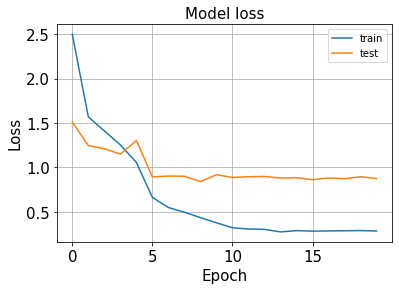

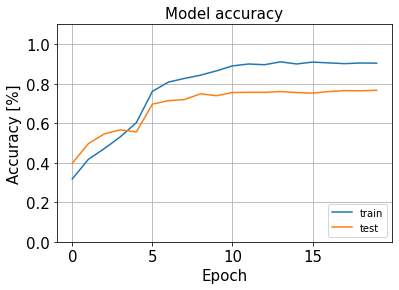

In [5]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 15



plt.rc('font', size=MEDIUM_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE) 
plt.rc('figure', titlesize=MEDIUM_SIZE) 

plt.plot(train_loss)
plt.plot(val_loss)
plt.grid(True);
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



plt.plot(train_acc)
plt.plot(val_acc)
plt.grid(True)
plt.ylim([0, 1.1])
plt.title('Model accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [96]:
##inference

from PIL import Image
image = Image.open("/content/drive/MyDrive/face/images/test/")
a = transforms.Compose([
        transforms.Resize((64,64)),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
image = a(image)
image = cutt(image) 
image.shape
image = image.reshape(1,3,64,64)

In [98]:
savePath =  "/content/drive/MyDrive/test/parameter_model.pth"

torch.save(model.state_dict(), savePath)

#loadPath ="" ##파라미터 경로 입력
#model.load_state_dict(torch.load(loadPath))
#model.to(device)
model.eval()


import matplotlib.pyplot as plt


out = model(image.to(device))



labels = ['surprise','sad','neutral','happy','angry']
_,preds = torch.max(out, 1)
print(preds)
print("Predicted class is: {}".format(labels[preds]))


tensor([4], device='cuda:0')
Predicted class is: angry
